## Initialization

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from IPython.display import display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pandas as pd

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

## EDA

In [4]:
def get_precent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls %'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    df_nulls = df_nulls.sort_values("Percent of Nulls %",ascending=False)
    return df_nulls

In [47]:
def explore(df):
    df = df
    print(df.head())
    print("Number of duplicated rows",df.duplicated().sum())
    print("Data shape",df.shape)
    print('Columns with nulls:')
    display(get_precent_of_na_df(df,4))
    display(df.info())
    display(df.describe())
    print("Number of duplicated rows")
    display(df.duplicated().sum())
    temp_raw_data=df.copy()
    fig1 = plt.figure(figsize = (14,5))
    ax = fig1.gca()
    temp_raw_data.hist(ax = ax, bins = 50)
    fig1 = ax.get_figure()
    fig2 = plt.figure(figsize = (14,5))
    ax = fig2.gca()
    temp_raw_data.boxplot(ax = ax)
    fig2 = ax.get_figure()
    fig3 = plt.figure(figsize = (14,5))
    ax = fig3.gca()
    temp_raw_data = df['real_age'].value_counts().reset_index()
    temp_raw_data.columns = ['real_age', 'count']
    temp_raw_data.plot.scatter(x='real_age', y='count', ax=ax);
    fig3 = ax.get_figure()

    file_name  real_age
0  000000.jpg         4
1  000001.jpg        18
2  000002.jpg        80
3  000003.jpg        50
4  000004.jpg        17
Number of duplicated rows 0
Data shape (7591, 2)
Columns with nulls:


,Missing Values,Percent of Nulls %
file_name,0,0.0
real_age,0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Number of duplicated rows


0

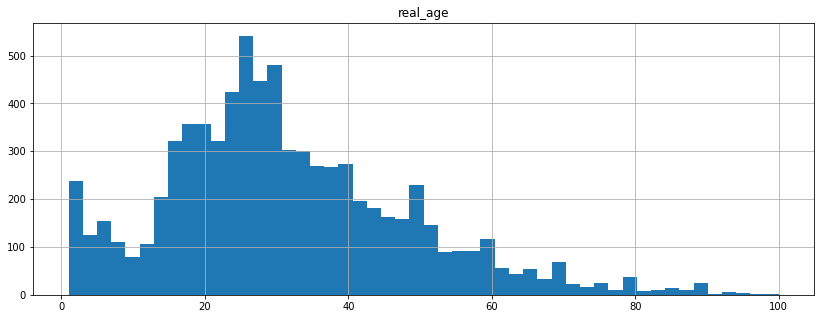

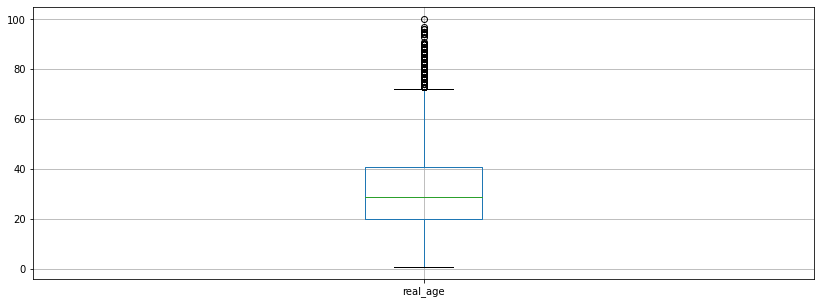

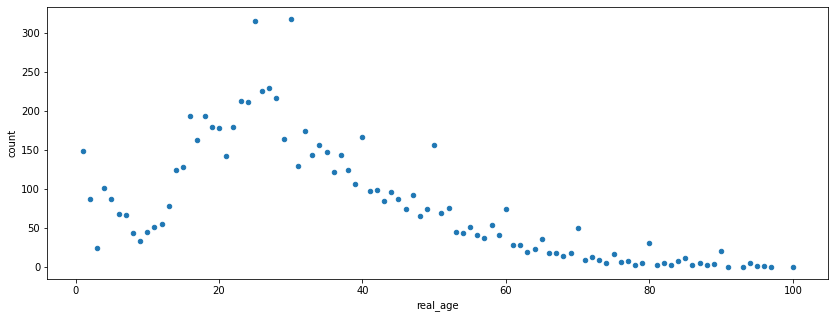

In [48]:
explore(labels)

### Findings: 

The scatter plot shows that our dataset consists of primarily people between the age of 10-60, peaking at mid 20s. The distribution is right skewed for older age with few outliers below the age of 10. This means that the mean age is higher than the median.
Perhaps a transformation could be done to ensure taht out modelling is not biased. In the current status of the distribution, our model would not classify older people with accuracy. <br>

The scatterplot also shows that out data is multimodal with outliers scatters along the curve. This also confirms that some type of transformation is warranted. Alternatively, we can use data augmentation.

In [7]:
datagen = ImageDataGenerator(validation_split = 0.25, rescale = 1./255, horizontal_flip = True)

In [8]:
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [10]:
len(train_gen_flow)

238

In [11]:
features, target = next(train_gen_flow)

In [12]:
features.shape

(32, 224, 224, 3)

In [13]:
target.shape

(32,)

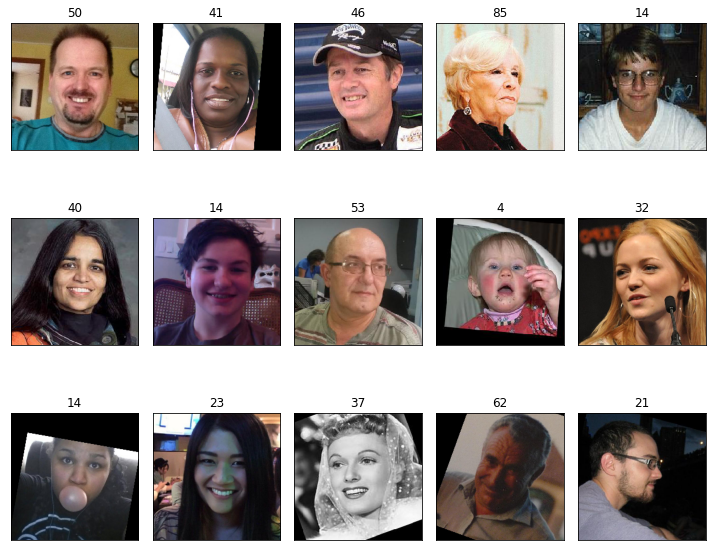

In [14]:
fig = plt.figure(figsize=(10,10))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    ax.set_title(target[i])
    plt.imshow(features[i])
    # remove axes and place the images closer to one another for a more compact output
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Findings

The shape of the features reveal a three-dimensional array.  This means that we are working with colored images. This can be seen in the sample pictures following. There is much diversity in gender, race age within our dataset, but in our case we're creating a model to simply determine age. These findings should help inform the modelling. <br>

Since we are training a dataset of images, we will use ReLU as our activation function. This will allow us to add more layers to our model to process the images. We will use the Adam algorithm and set the learning rate lower to improve the overall quality of the model.<br>

Since we're working with more than 7000 images, we'll use ImageDataGenerator from the Keras library to implement dynamic data loading. Moreover, since our data is skewed,  we will use augmentation to artificially expand our dataset.  We will aslo use the ResNet architecture to improve our model even further, and train our model on imagenet first before adding the next layers to get better results.

## Modelling

In [15]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [50]:
def load_train(path):
    """
    It loads the train part of dataset from path
    """
    
    train_datagen = ImageDataGenerator(rescale= 1/255, validation_split=0.25)  
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

In [51]:
def load_test(path):
    """
    It loads the validation/test part of dataset from path
    """
    
    labels = pd.read_csv(path+'labels.csv')  
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)  
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation', 
        seed=42)

    return test_datagen_flow

In [52]:
def create_model(input_shape):
    """
    It defines the model
    """
    
    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet', 
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae']) 
    return model

In [53]:
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    """
    Trains the model given the parameters
    """

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data, 
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

### Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [54]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

## Output

Place the output from the GPU platform as an Markdown cell here.

Train for 178 steps, validate for 60 steps
Epoch 1/10
2022-12-28 23:25:26.187389: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-12-28 23:25:26.949427: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 56s - loss: 192.3853 - mae: 10.4485 - val_loss: 423.7188 - val_mae: 15.4622
Epoch 2/10
178/178 - 37s - loss: 100.4927 - mae: 7.6290 - val_loss: 487.5566 - val_mae: 16.9459
Epoch 3/10
178/178 - 38s - loss: 65.4425 - mae: 6.2171 - val_loss: 343.4963 - val_mae: 13.7127
Epoch 4/10
178/178 - 38s - loss: 40.5747 - mae: 4.9249 - val_loss: 168.7708 - val_mae: 10.3520
Epoch 5/10
178/178 - 38s - loss: 28.4009 - mae: 4.1120 - val_loss: 103.3700 - val_mae: 7.5446
Epoch 6/10
178/178 - 38s - loss: 20.2136 - mae: 3.4690 - val_loss: 75.5848 - val_mae: 6.5771
Epoch 7/10
178/178 - 38s - loss: 15.2231 - mae: 3.0061 - val_loss: 74.4689 - val_mae: 6.5108
Epoch 8/10
178/178 - 37s - loss: 12.6535 - mae: 2.7282 - val_loss: 72.7530 - val_mae: 6.5589
Epoch 9/10
178/178 - 38s - loss: 11.1128 - mae: 2.5529 - val_loss: 70.3470 - val_mae: 6.2986
Epoch 10/10
178/178 - 37s - loss: 10.8142 - mae: 2.5005 - val_loss: 73.4034 - val_mae: 6.4675
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 73.4034 - mae: 6.4675
Test MAE: 6.4675

## Conclusions

Test MAE value is of 6.4675. Our goal was an MAE value below 7, and we have accomplished that from the 6th epochs.<br>

The value for our validation set's loss function is higher than the training set's loss function, which could mean a slight overfitting. We are confident that our model can be used to determine a person's age using an image. This can be utilized for several purposes such as collecting data on customers to identify similar purchases habits between customers of the same age, using that data to target advertisements to certain age groups, and determining the age of a customer at a checkout counter to automate the approval or disapproval of a sale of alcohol. The model is recommended for implementation to automate the recommendation system to predict real age of buyer in the shop when selling alcohol.